## Behaviour if grouping and calculating the mean if NaN-values are in the group

In [152]:
import pandas as pd
import numpy as np


### Test cases to illustrate grouping on NaN values


In [153]:
# Case 1: no NaN
s1 = pd.Series([1, 2, 3])
print("Case 1 mean:", s1.mean())  # 2.0

# Case 2: some NaN
s2 = pd.Series([1, np.nan, 3])
print("Case 2 mean:", s2.mean())  # 2.0 (ignores NaN)

# Case 3: all NaN
s3 = pd.Series([np.nan, np.nan])
print("Case 3 mean:", s3.mean())  # NaN

Case 1 mean: 2.0
Case 2 mean: 2.0
Case 3 mean: nan


### Load the data and minmal adjustments

In [154]:
# Load merged hourly dataset
df = pd.read_csv("../../data_cleaned/merged/Merge_all_prices_load_gen_res.csv")
# Convert timestamp columns to datetime
df["period_start_utc"] = pd.to_datetime(df["period_start_utc"], utc=True, errors="coerce")
df["period_end_utc"] = pd.to_datetime(df["period_end_utc"], utc=True, errors="coerce")

# Optional: convert date column if needed
df["date"] = pd.to_datetime(df["date"], errors="coerce")
# Basic cleaning and sorting
# df["gen_forecast_da"] = pd.to_numeric(df["gen_forecast_da"], errors="coerce")
# df["load_forecast_da"] = pd.to_numeric(df["load_forecast_da"], errors="coerce")
df = df.sort_values("period_start_utc")

df.head(2)

,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,off_wind_da,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act
0,2015-01-04,2015,1,4,4,23,1,6,22.34,2015-01-04 23:00:00+00:00,...,192.125,478.0200,11675.5250,14223.2775,0.0,0.1700,NaN,57028.5925,11867.6500,14701.4675
1,2015-01-05,2015,1,5,5,0,2,0,17.93,2015-01-05 00:00:00+00:00,...,192.375,468.5525,11924.5575,14207.5025,0.0,0.2075,NaN,56318.8525,12116.9325,14676.2625


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96336 entries, 0 to 96335
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   date              96336 non-null  datetime64[ns]     
 1   year              96336 non-null  int64              
 2   month             96336 non-null  int64              
 3   day               96336 non-null  int64              
 4   dayofyear         96336 non-null  int64              
 5   hour              96336 non-null  int64              
 6   week              96336 non-null  int64              
 7   dayofweek         96336 non-null  int64              
 8   price             96336 non-null  float64            
 9   period_start_utc  96336 non-null  datetime64[ns, UTC]
 10  period_end_utc    96336 non-null  datetime64[ns, UTC]
 11  c_by_hour         96336 non-null  int64              
 12  load_forecast_da  95229 non-null  float64            
 13  l

#### Create helper column

In [156]:

df["actual_diff_perc"] = (df["load_actual"] - df["gen_actual"]) / df["load_actual"].replace(0, pd.NA) * 100
df["da_diff_perc"] = (df["load_forecast_da"] - df["gen_forecast_da"]) / df["load_forecast_da"].replace(0, pd.NA) * 100


#### Function to plot 

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_load_and_diff(
    df,
    start_date,
    end_date,
    feature_cols,  #=("load_forecast_da", "load_actual"),
    diff_col,      #="load_diff_perc",
    date_col="period_start_utc",
    vline_color="#555555",
    vline_alpha=0.4,
    vline_width=0.4
):
    df_plot = df.copy()
    df_plot = df_plot[df_plot[date_col].between(start_date, end_date)].copy()
    df_plot = df_plot.sort_values(date_col)

    df_hourly = df_plot[[date_col, diff_col] + list(feature_cols)]

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 2]}
)

    # Top: features
    for col in feature_cols:
        ax1.plot(
            df_hourly[date_col],
            df_hourly[col],
            alpha=0.6,
            linewidth=0.8,
            marker="o",
            markersize=2,
            label=col
        )
    ax1.set_ylabel("mega watt (MW)")
    ax1.legend(loc="upper left", ncol=2, fontsize=8)

    # Bottom: diff column
    ax2.plot(
        df_hourly[date_col],
        df_hourly[diff_col],
        color="black",
        linewidth=1.2,
        # marker="o",
        # markersize=2,
        label=diff_col
    )
    ax2.set_ylabel(diff_col)
    ax2.set_xlabel("Dates")
    ax2.legend(loc="upper left", fontsize=8)

    # Thin lines for each day
    for dt in pd.date_range(
        df_hourly[date_col].min().normalize(),
        df_hourly[date_col].max().normalize(),
        freq="D"
    ):
        ax1.axvline(dt, color=vline_color, linewidth=vline_width, alpha=vline_alpha)
        ax2.axvline(dt, color=vline_color, linewidth=vline_width, alpha=vline_alpha)

    plt.tight_layout()
    plt.show()


#### Plot the two critical moments for load

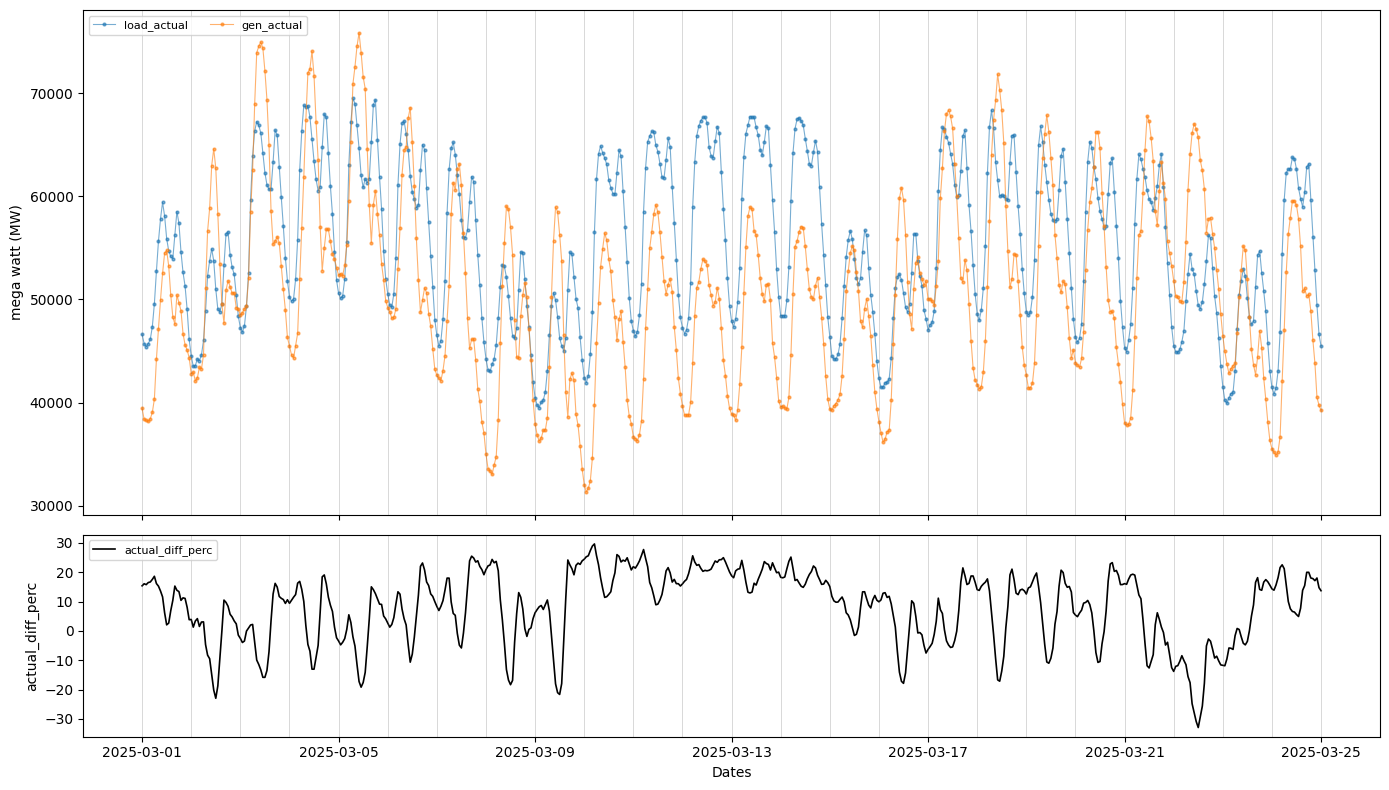

In [158]:
plot_load_and_diff(
    df, "2025-03-01", "2025-03-25",
    feature_cols=("load_actual", "gen_actual"),
    diff_col="actual_diff_perc"
)

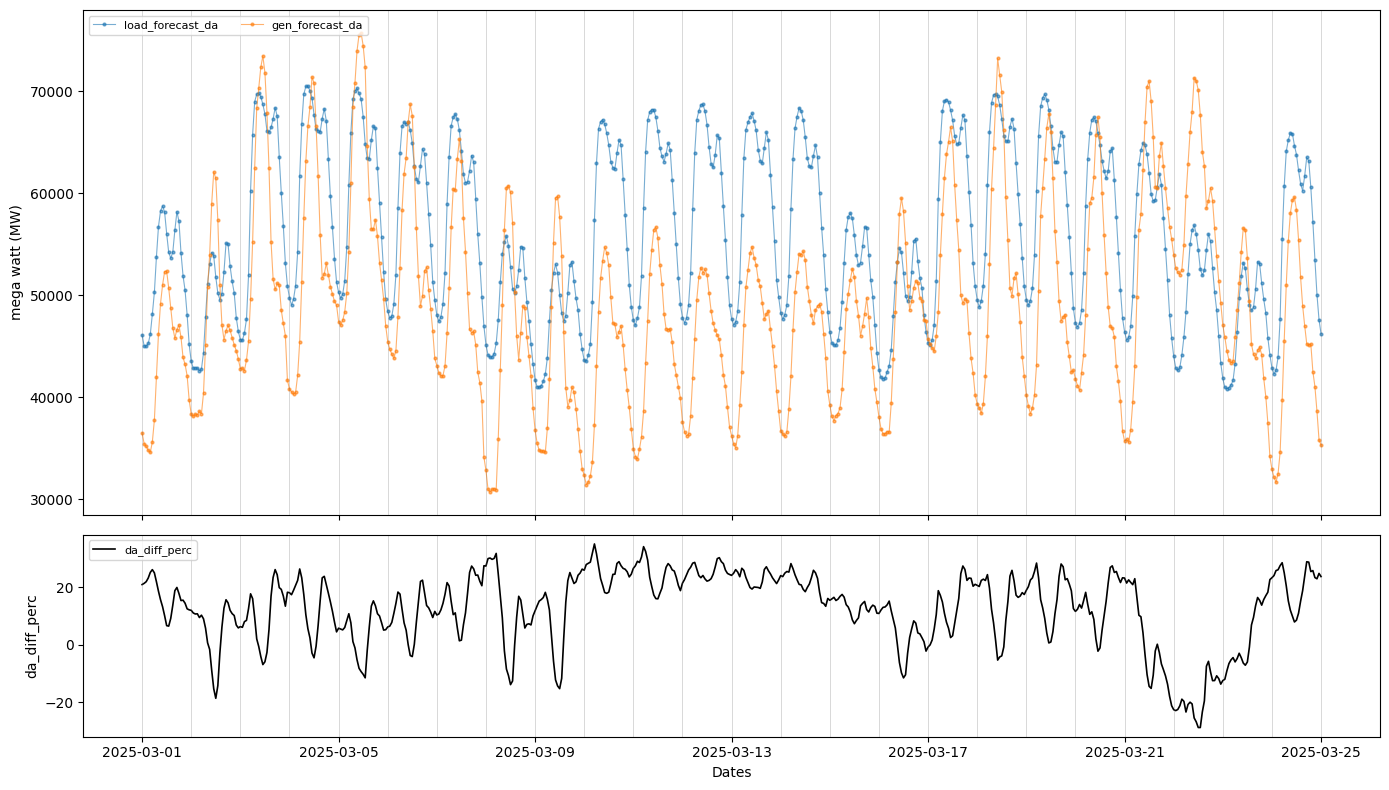

In [159]:
plot_load_and_diff(
    df, "2025-03-01", "2025-03-25",
    feature_cols=("load_forecast_da", "gen_forecast_da"),
    diff_col="da_diff_perc"
)

### more compares

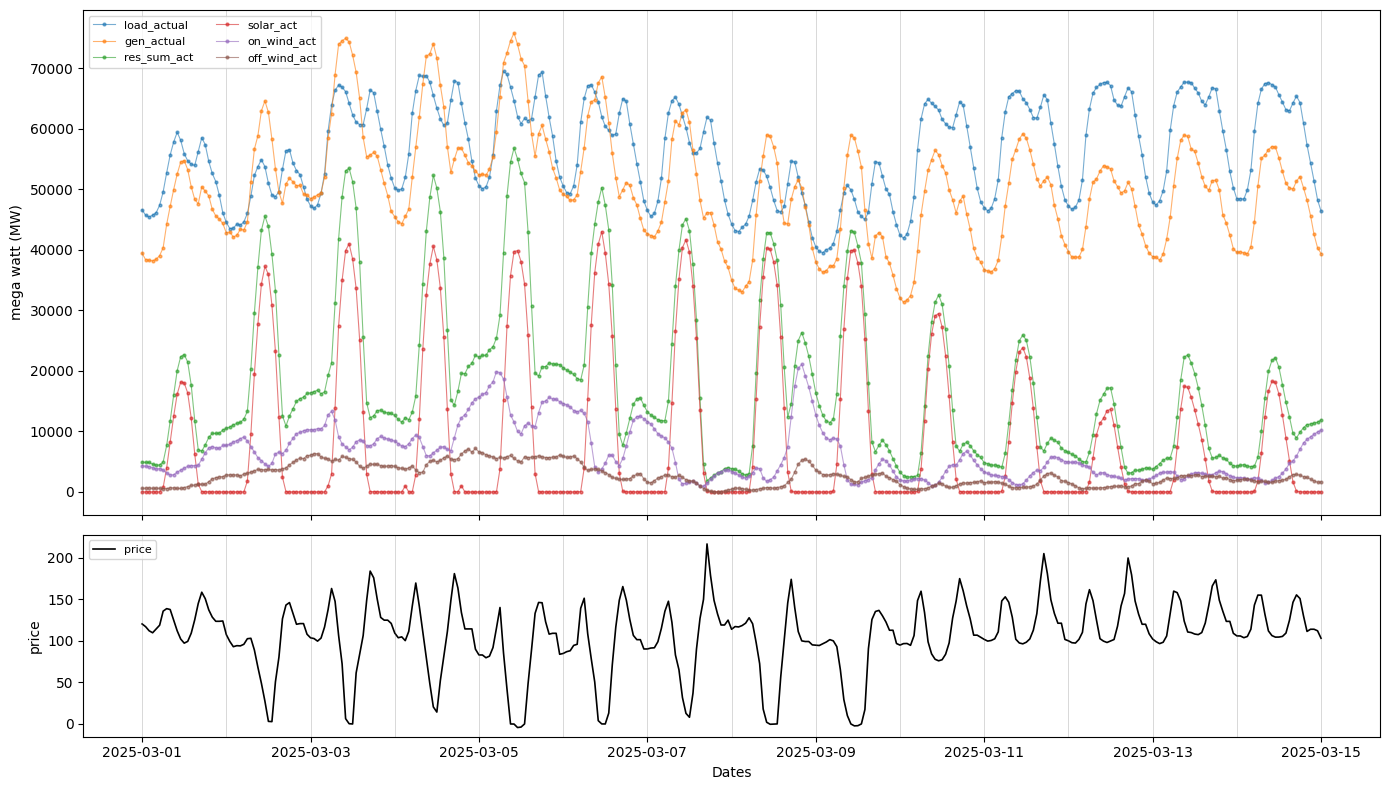

In [160]:
plot_load_and_diff(
    df, "2025-03-01", "2025-03-15",
    feature_cols=("load_actual", "gen_actual",'res_sum_act','solar_act','on_wind_act', 'off_wind_act'),
    diff_col="price"
)

#### All da Prices

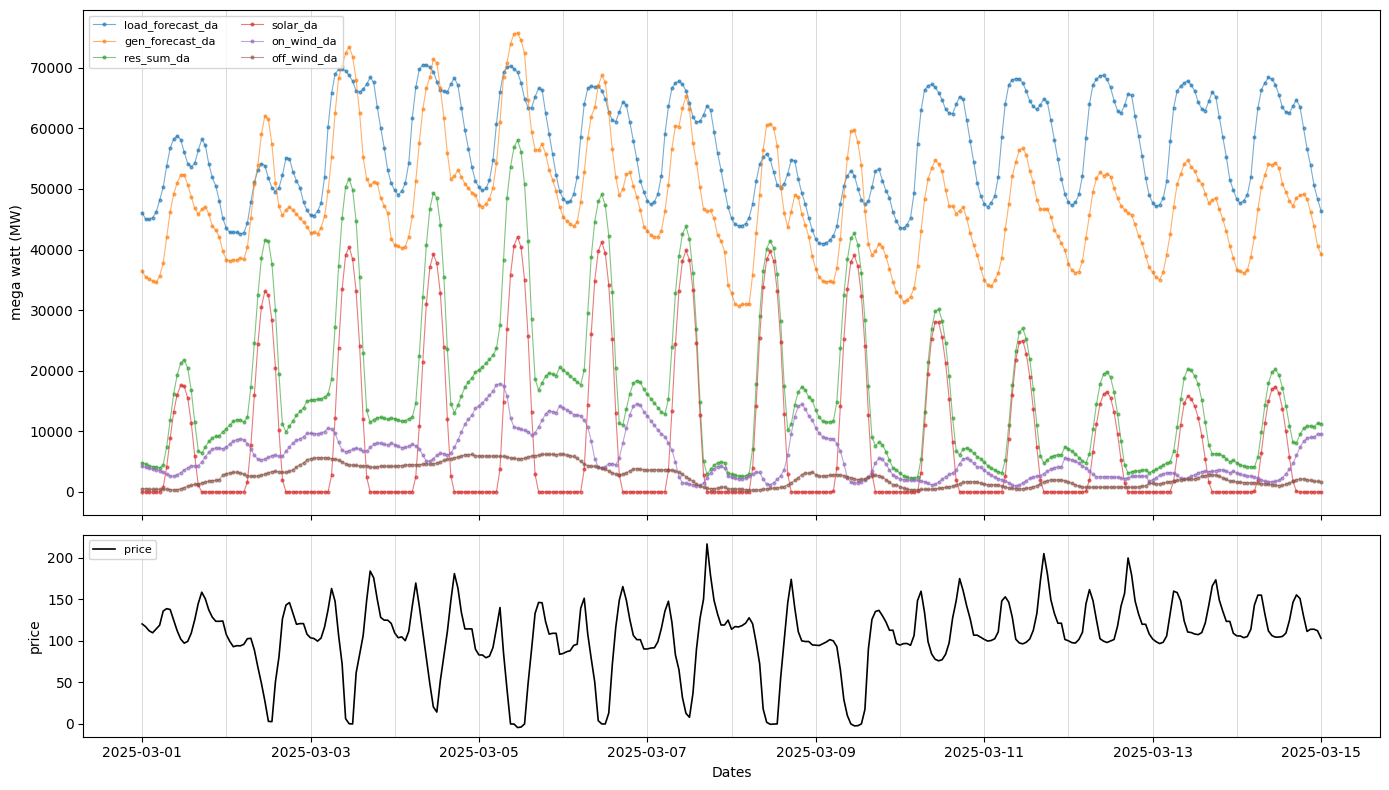

In [161]:
plot_load_and_diff(
    df, "2025-03-01", "2025-03-15",
    feature_cols=("load_forecast_da", "gen_forecast_da",'res_sum_da','solar_da','on_wind_da', 'off_wind_da'),
    diff_col="price"
)

### investigation on prices and res_sum_da

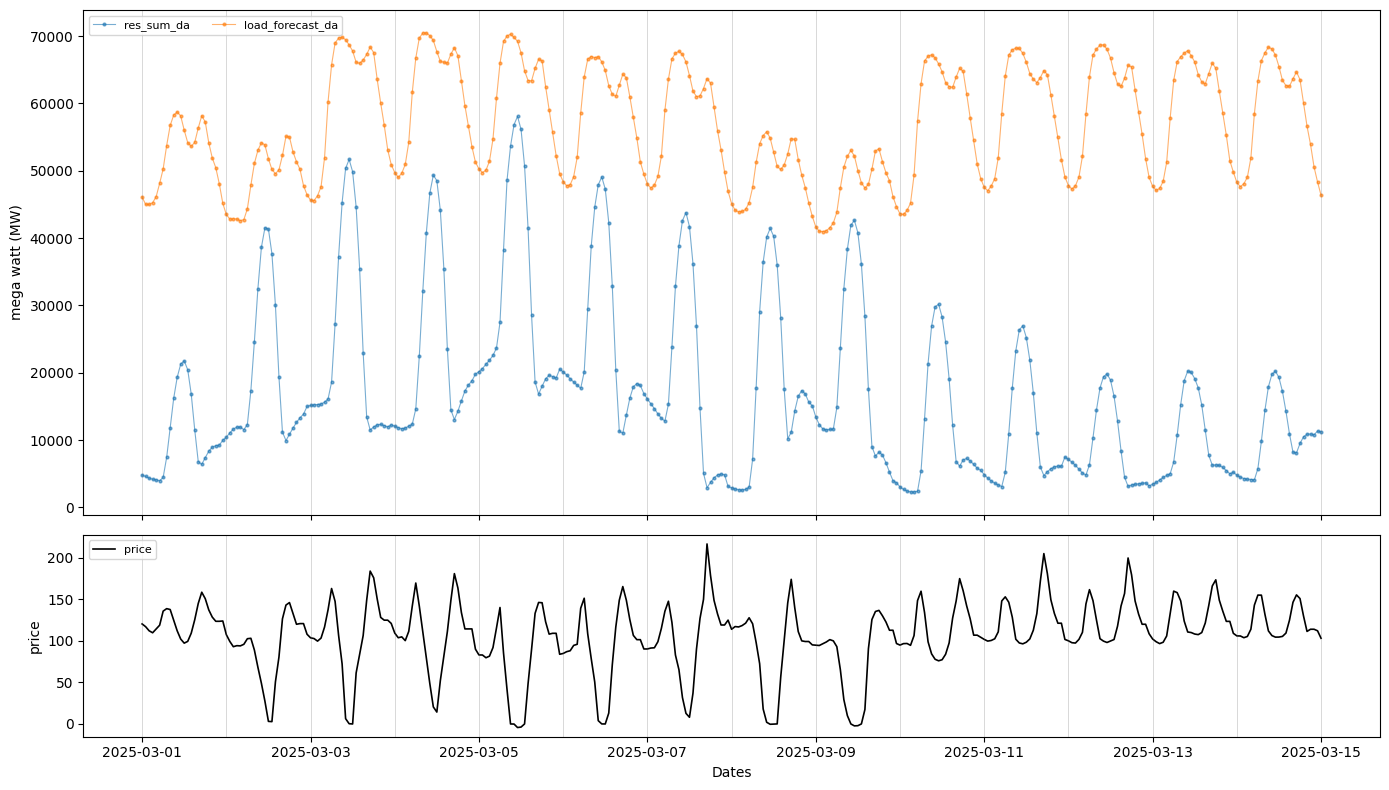

In [162]:
plot_load_and_diff(
    df, "2025-03-01", "2025-03-15",
    feature_cols=('res_sum_da','load_forecast_da'),
    diff_col="price"
)

### more helper columns to find a baseline formular

In [172]:
df["load_res_avg_da"] = (df["load_forecast_da"] * 2 + df["res_sum_da"] * 4).replace(0, pd.NA) * 0.5

df["price_neg"] = df["price"].replace(0, pd.NA) * (-1)

df["price_neg-t350"] = df["price"].replace(0, pd.NA) * (-350)

#### delete the helper column

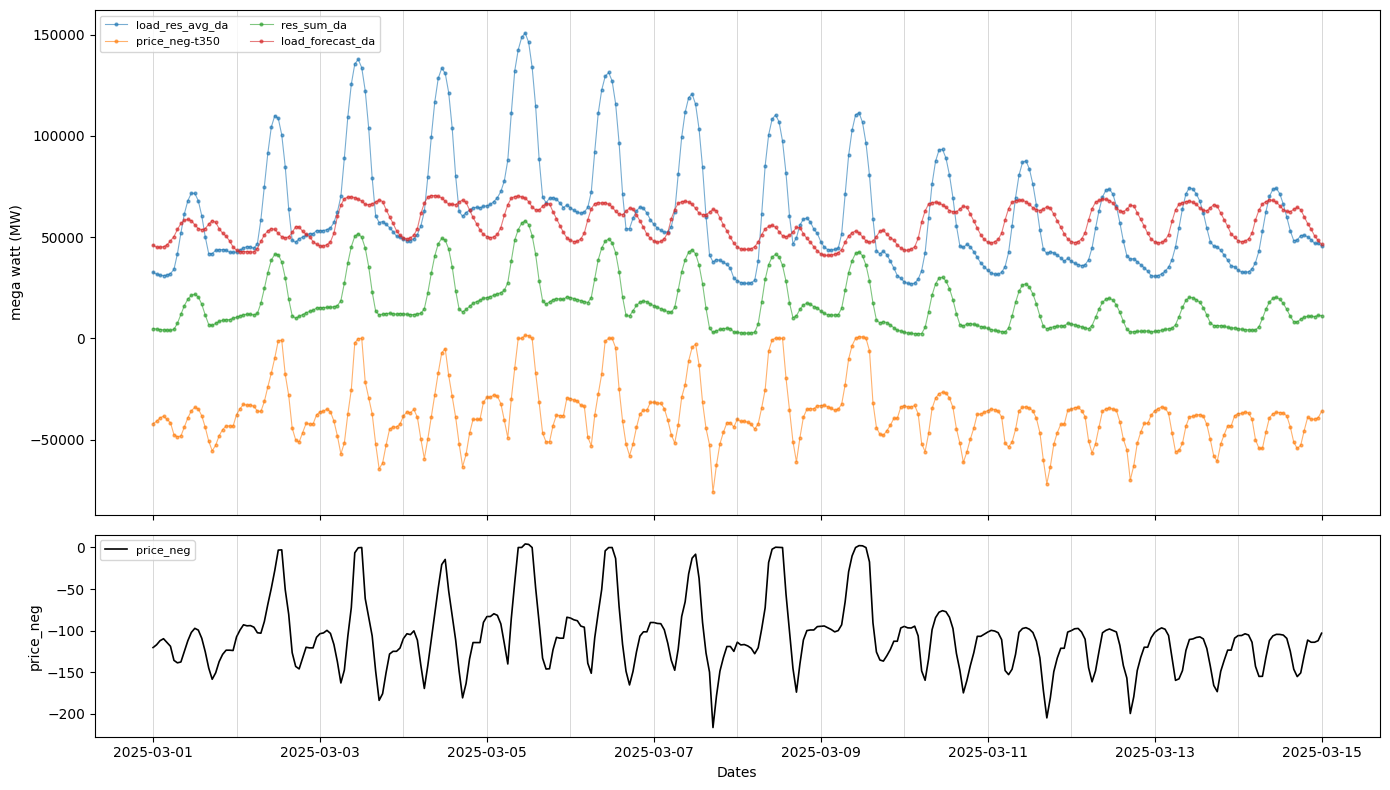

In [171]:
plot_load_and_diff(
    df, "2025-03-01", "2025-03-15",
    feature_cols=('load_res_avg_da','price_neg-t350','res_sum_da', 'load_forecast_da'),
    diff_col="price_neg"
)

In [116]:
df.drop(columns=["load_diff_perc"], inplace=True)

### Appendix